In [1]:
!ls results/separability

data					sep_sized_TransH_50d_120e.csv
img					separability_ComplEx_50d_60e.csv
sep_sized_ComplEx_50d_60e.csv		separability_DistMult_50d_100e.csv
sep_sized_DistMult_50d_100e.csv		separability_HolE_50d_60e.csv
sep_sized_HolE_50d_60e.csv		separability_RDF2Vec_200d_uniform.csv
sep_sized_RDF2Vec_200d_uniform.csv	separability_TransD_50d_50e.csv
sep_sized_RDF2Vec_200d_uniform_old.csv	separability_TransE_50d_100e.csv
sep_sized_TransD_50d_50e.csv		separability_TransH_50d_120e.csv
sep_sized_TransE_50d_100e.csv		separability_TransH_50d_150e.csv
sep_sized_TransE_50d_100e_old.csv


In [57]:
import os

RESDIR = "results/separability/img/"

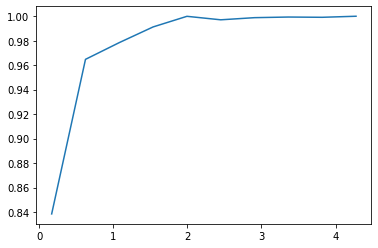

In [58]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools as it
from libs.utils import jitter
from matplotlib.cm import get_cmap
import scipy.stats

def symmetrize(df):
    df2 = df[["b", "a", "cb", "ca", "taxo", "geom", "mixed", "prec", "rec", "f1", "acc", "model"]]
    df2.columns = df.columns
    df_sym = pd.concat([df, df2])
    return df_sym
steps = np.concatenate([
    np.arange(0, 2, 0.5),
    np.arange(2, 6, 1)
])
step = 0.1
a = np.arange(0, 1, step)
b = zip(a[:-1], a[1:])

models = ["ComplEx_50d_60e",
        "DistMult_50d_100e",
        #"HolE_50d_60e",
        "RDF2Vec_200d_uniform",
        "TransE_50d_100e",
        "TransH_50d_120e",
          "TransD_50d_50e"
         ]
MODEL = {m.split("_")[0]: m for m in models}

def load_df(m):
    m = MODEL.get(m, m)
    df = pd.read_csv(f"results/separability/sep_sized_{m}.csv", index_col=0)
    return symmetrize(df)

def load_df(m, sym=False):
    df = pd.read_csv(f"results/separability/data/sep_{m}.csv", index_col=0)
    if sym:
        return symmetrize(df)
    return df

def mean_confidence_interval(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return m, h

def aggregate(select, values, steps, func=np.mean):
    bounds = []
    results = []
    if isinstance(steps, int):
        n_step = steps
        m = select.min()
        M = select.max()
        step = (M - m) / n_step
        steps = np.arange(m, M+step, step)
    for a, b in zip(steps, steps[1:]):
        data = values.loc[(select > a) & (select <= b)]
        if not len(data):
            continue
        bounds.append(a)
        results.append(func(data))
    return bounds, results

df = load_df("TransE")
plt.plot(*aggregate(df.taxo, df.f1, 10))
plt.show()

In [59]:
for model in MODEL:
    df = load_df(model)
    p = 100*df.prec.mean()
    r = 100*df.rec.mean()
    f = 100*df.f1.mean()
    print(f"{model:10}\t{p:.1f}\t{r:.1f}\t{f:.1f}")

ComplEx   	90.4	89.9	89.7
DistMult  	92.5	91.6	91.6
RDF2Vec   	99.7	99.7	99.7
TransE    	99.4	99.1	99.2
TransH    	93.6	92.1	92.5
TransD    	85.0	83.1	83.5


In [60]:
MODEL = {m.split("_")[0]: m for m in models}

def load_df(m):
    m = MODEL.get(m, m)
    df = pd.read_csv(f"results/separability/sep_sized_{m}.csv", index_col=0)
    return symmetrize(df)

def load_df(m, sym=False):
    df = pd.read_csv(f"results/separability/data/sep_{m}.csv", index_col=0)
    if sym:
        return symmetrize(df)
    return df

ComplEx


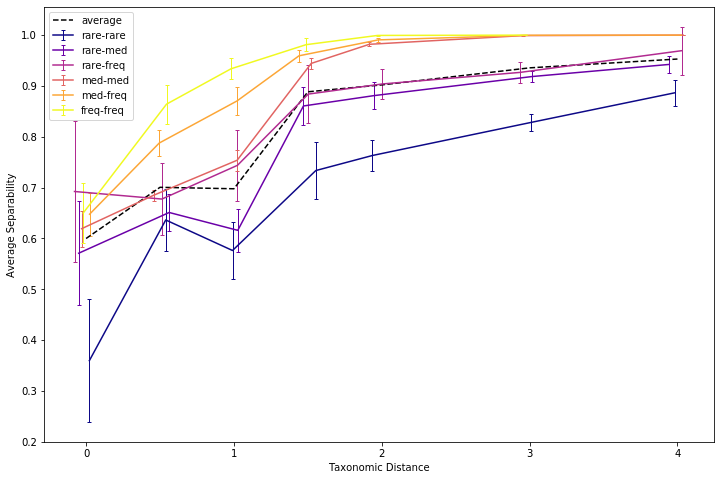

DistMult


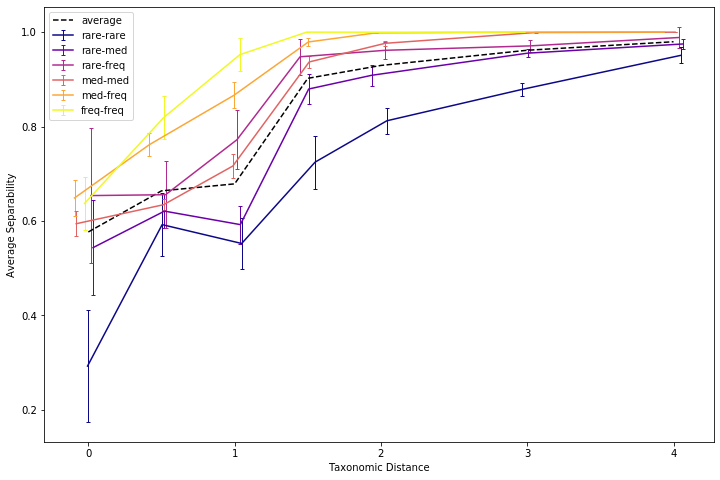

RDF2Vec


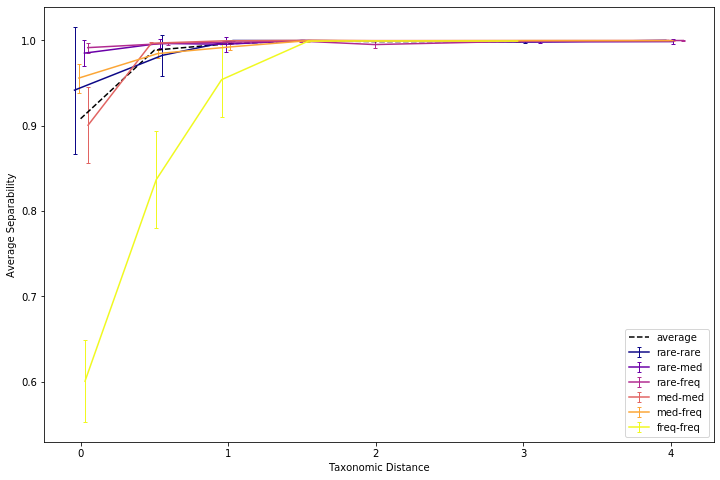

TransE


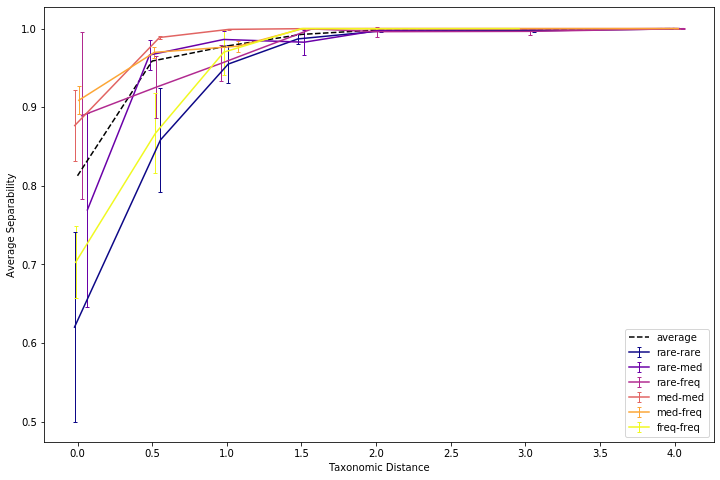

TransH


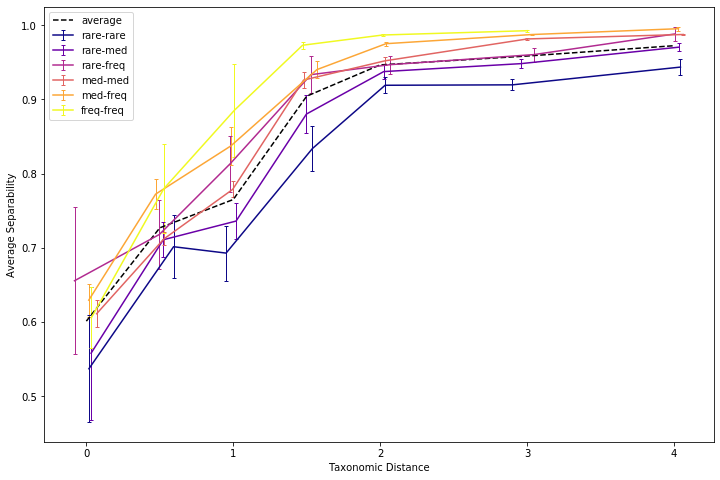

TransD


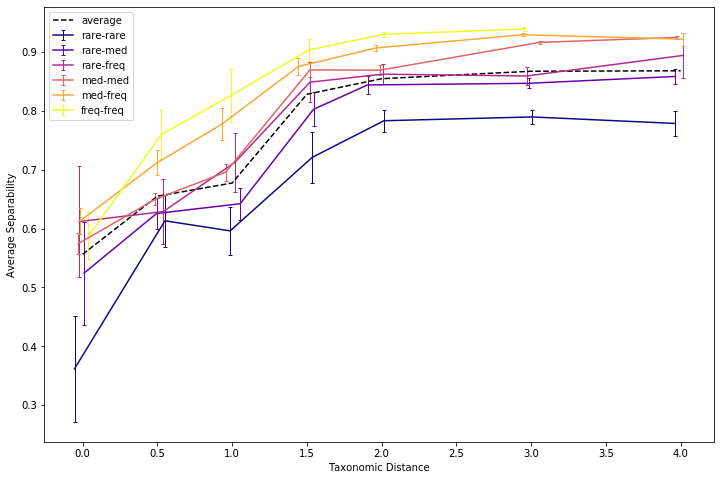

In [61]:
steps = np.concatenate([
    np.arange(0, 2, 0.5),
    np.arange(2, 6, 1)
])

model = "TransE_50d_100e"
models = ["ComplEx_50d_60e",
        "DistMult_50d_100e",
        #"HolE_50d_60e",
        "RDF2Vec_200d_uniform",
        "TransE_50d_100e",
        "TransH_50d_120e",
          "TransD_50d_50e"
         ]
MODEL = {m.split("_")[0]: m for m in models}

verbose = False
for model in models:
    model_name = model.split("_")[0]
    df = pd.read_csv(f"results/separability/sep_sized_{model}.csv", index_col=0)

    df = symmetrize(df)
    t1 = 1000
    t2 = 100000


    dones = set()
    locs = [(
                ((df[col] < t1), "rare"), 
                (((df[col] >= t1) & (df[col] < t2)), "med"), 
                ((df[col] >= t2), "freq") 
            )   for col in ["ca", "cb"]]

    total = 5
    curr = 0
    colors = get_cmap("plasma")

    print(model_name)
    plt.figure(figsize=(12, 8))
    for (loca, na), (locb, nb) in it.product(*locs):
        if (na, nb) in dones or (nb, na) in dones:
            continue
        col = colors(curr / total)
        curr += 1
        dones.add((na, nb))
        data = df.loc[loca & locb]
        if verbose: print(f"{na}-{nb}: {len(data)}")
        x, ys = aggregate(data.taxo, data.f1, steps, func=mean_confidence_interval)
        y, err = zip(*ys)
        #plt.plot(x, y, label=f"{na}-{nb}")
        plt.errorbar(jitter(x), y, yerr=err, label=f"{na}-{nb}", c=col, elinewidth=1, capsize=2)

    x, ys = aggregate(df.taxo, df.f1, steps, func=mean_confidence_interval)
    y, err = zip(*ys)
    plt.plot(x, y, label="average", c="k", linestyle="--")
    #print(f"0-{t1-1}: {len(df_rare)}, {t1}-{t2-1}: {len(df_med)}, {t2}+: {len(df_freq)}")
    #plt.plot(*aggregate(df_rare.taxo, df_rare.f1, np.arange(0, 5, 0.25)), label="rare")
    #plt.plot(*aggregate(df_med.taxo, df_med.f1, np.arange(0, 5, 0.25)), label="med")
    #plt.plot(*aggregate(df_freq.taxo, df_freq.f1, np.arange(0, 5, 0.25)), label="freq")
    plt.legend()
    plt.xlabel("Taxonomic Distance")
    plt.ylabel("Average Separability")
    #plt.title(f"Separability for different distances and class sizes for {model_name}")
    #plt.savefig(f"results/separability/img/sizedep_{model}_v2.png", format="png")
    #plt.savefig(f"results/separability/img/sizedep_{model}_v2.eps", format="eps")
    plt.show()

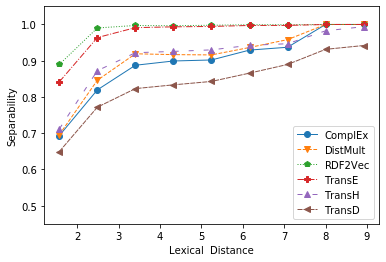

In [62]:
from collections import defaultdict

steps = np.concatenate([
    np.arange(0, 2, 0.5),
    np.arange(2, 6, 1)
])
verbose = False
#model = "RDF2Vec_200d_uniform"
colors = get_cmap("plasma")
def color(model): return colors(models.index(model)/len(models))
loosely_dotted = (0, (5, 10))
linestyles = ["solid", "dashed", "dotted", "dashdot",  (0, (5, 10)), (0, (5, 1))]
markers = ["o", "v", "p", "P", "^", "<"]
style = zip(linestyles, markers)

models = ["ComplEx_50d_60e",
        "DistMult_50d_100e",
        "RDF2Vec_200d_uniform",
        "TransE_50d_100e",
        "TransH_50d_120e",
          "TransD_50d_50e"
         ]

#for ls, model in zip(linestyles, models):
distance = "euc"
distances = defaultdict(lambda : "", {"mixed": "Mixed ", "taxo": "Taxonomic ", "geom": "Geometric ", "euc": "Lexical ", "cos": "Lexical ", "neuc": "Lexical "})
#plt.figure(figsize=(12, 8))

for (ls, mk), model in zip(style, MODEL):
    #if "HolE" in model:continue
    #model_name = model.split("_")[0]
    #df = pd.read_csv(f"results/separability/sep_sized_{model}.csv", index_col=0)
    #df = symmetrize(df)
    df = load_df(model)
    
    x, ys = aggregate(df[distance], df.f1, 8, func=mean_confidence_interval)
    y, err = zip(*ys)
    plt.plot(x, y, label=model, linestyle=ls, marker=mk, linewidth=1)#, c=color(model))
    #plt.scatter(x, y)
    
plt.legend()
plt.xlabel(f"{distances[distance]} Distance")
plt.ylabel("Separability")
epsilon = 0.05
plt.ylim([0.5-epsilon, 1+epsilon])
#plt.title(f"Separability for different distances and class sizes for {model_name}")
SAVE = False
if SAVE:
    filename = f"results/separability/img/avg_separability-{distance}_dist"
    plt.savefig(filename+".png", format="png")
    plt.savefig(filename+".eps", format="eps")
    plt.savefig(filename+".svg", format="svg")
plt.show()
if SAVE:
    print(f"Saved to '{filename}.eps'")

ComplEx
DistMult
RDF2Vec
TransE


/home/mexil/.local/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/mexil/.local/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


TransH
TransD


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<Figure size 432x288 with 0 Axes>

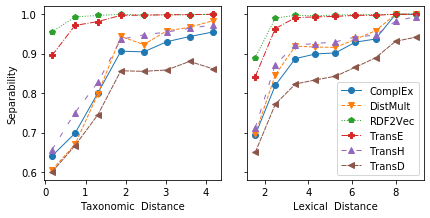

Saved to 'results/separability/img/avg_separability-shared_small2.eps'


In [67]:
from collections import defaultdict

steps = np.concatenate([
    np.arange(0, 2, 0.5),
    np.arange(2, 6, 1)
])
verbose = False
#model = "RDF2Vec_200d_uniform"
colors = get_cmap("plasma")
def color(model): return colors(models.index(model)/len(models))
loosely_dotted = (0, (5, 10))
linestyles = ["solid", "dashed", "dotted", "dashdot",  (0, (5, 10)), (0, (5, 1))]
markers = ["o", "v", "p", "P", "^", "<"]
style = list(zip(linestyles, markers))

models = ["ComplEx_50d_60e",
        "DistMult_50d_100e",
        "RDF2Vec_200d_uniform",
        "TransE_50d_100e",
        "TransH_50d_120e",
          "TransD_50d_50e"
         ]

#for ls, model in zip(linestyles, models):
plt.subplots_adjust(top=0.98)
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(6, 3))

fig.tight_layout()
distance = "taxo"
distances = defaultdict(lambda : "", {"mixed": "Mixed ", "taxo": "Taxonomic ", "geom": "Geometric ", "euc": "Lexical ", "cos": "Lexical ", "neuc": "Lexical "})
#plt.figure(figsize=(12, 8))

for (ls, mk), model in zip(style, MODEL):
    #if "HolE" in model:continue
    #model_name = model.split("_")[0]
    #df = pd.read_csv(f"results/separability/sep_sized_{model}.csv", index_col=0)
    #df = symmetrize(df)
    df = load_df(model)
    
    x, ys = aggregate(df[distance], df.f1, 8, func=mean_confidence_interval)
    y, err = zip(*ys)
    ax1.plot(x, y, label=model, linestyle=ls, marker=mk, linewidth=1)#, c=color(model))
    #plt.scatter(x, y)

#ax1.legend()
ax1.set(
    xlabel=f"{distances[distance]} Distance",
    ylabel="Separability"
)


#plt.subplot(212)
distance = "euc"

for (ls, mk), model in zip(style, MODEL):
    print(model)
    df = load_df(model)
    
    x, ys = aggregate(df[distance], df.f1, 8, func=mean_confidence_interval)
    y, err = zip(*ys)
    ax2.plot(x, y, label=model, linestyle=ls, marker=mk, linewidth=1)#, c=color(model))
    #plt.scatter(x, y)
   
ax2.legend()
ax2.set(
    xlabel=f"{distances[distance]} Distance",
    #ylabel="Separability"
)

#plt.title(f"Separability for different distances and class sizes for {model_name}")
SAVE = True
if SAVE:
    filename = f"results/separability/img/avg_separability-shared_small2"
    plt.savefig(filename+".png", format="png")
    plt.savefig(filename+".eps", format="eps")
    plt.savefig(filename+".svg", format="svg")

plt.show()
if SAVE:
    print(f"Saved to '{filename}.eps'")

In [64]:
df = load_df("TransE")
x, ys = aggregate(df[distance], df.f1, 8, func=mean_confidence_interval)
y, err = zip(*ys)
y[0]

0.8417237239469717

In [65]:
size, dist = df.hsize/df.hsize.max(), df.euc/df.euc.max()
print("covariance", np.cov(size, dist)[0, 0])

covariance 0.0019361990149345978


In [66]:
print("pearson", stats.pearsonr(size, dist))

pearson (-0.05798194908601976, 2.4100081319647415e-09)


In [15]:
print("spearman", stats.spearmanr(size, dist))

NameError: name 'stats' is not defined

In [16]:
import stats

ModuleNotFoundError: No module named 'stats'

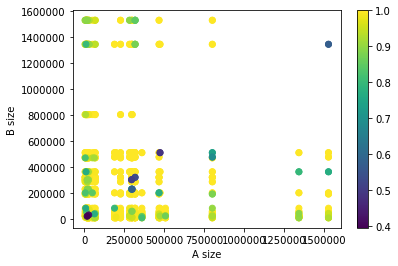

In [17]:
freqs = set(df.loc[df.ca > 1e5].a.unique())

#view = df.loc[(df.a.isin(freqs)) | (df.b.isin(freqs))]
view = df.loc[df.hsize > 1e4].sort_values(by="f1", ascending=False)
plt.scatter(view.ca, view.cb, c=view.f1)
plt.xlabel("A size")
plt.ylabel("B size")
#plt.yscale("log")
#plt.xscale("log")
plt.colorbar()
plt.show()

In [18]:
view = df.loc[df.hsize > 1e4].sort_values(by="f1", ascending=True)
view.head(15)

,a,b,ca,cb,taxo,geom,mixed,prec,rec,f1,acc,model,hsize,gsize,cos,euc,neuc,taxcos,taxeuc,taxneuc
7542,dbo:SoccerManager,dbo:SportsManager,18622,18622,0.250000,0.000000,0.125000,0.457627,0.346154,0.394161,0.446667,TransE_50d_100e,1.862200e+04,1.862200e+04,0.193684,1.970129,0.622389,0.116964,0.136859,0.239194
7185,dbo:River,dbo:Stream,28445,28914,0.200000,0.001139,0.100570,0.430556,0.407895,0.418919,0.426667,TransE_50d_100e,2.867758e+04,2.867854e+04,0.482826,4.143349,0.982676,0.246869,0.253413,0.357090
9536,dbo:Settlement,dbo:PopulatedPlace,474250,508093,0.333333,0.016895,0.175114,0.551724,0.432432,0.484848,0.546667,TransE_50d_100e,4.905885e+05,4.908799e+05,0.748723,4.763358,1.223702,0.385272,0.302257,0.453578
6535,dbo:Settlement,dbo:PopulatedPlace,474250,508093,0.333333,0.016895,0.175114,0.551724,0.432432,0.484848,0.546667,TransE_50d_100e,4.905885e+05,4.908799e+05,0.748723,4.763358,1.223702,0.385272,0.302257,0.453578
728,dbo:Eukaryote,dbo:Species,296366,300153,0.500000,0.002948,0.251474,0.481928,0.526316,0.503145,0.473333,TransE_50d_100e,2.982475e+05,2.982535e+05,0.570220,5.676272,1.067914,0.319420,0.371043,0.417921
2225,dbo:Eukaryote,dbo:Species,296366,300153,0.500000,0.002948,0.251474,0.481928,0.526316,0.503145,0.473333,TransE_50d_100e,2.982475e+05,2.982535e+05,0.570220,5.676272,1.067914,0.319420,0.371043,0.417921
4879,dbo:OrganisationMember,dbo:SportsTeamMember,318392,318392,0.250000,0.000000,0.125000,0.539474,0.525641,0.532468,0.520000,TransE_50d_100e,3.183920e+05,3.183920e+05,0.333275,2.450087,0.816425,0.182229,0.163766,0.305533
4579,dbo:OrganisationMember,dbo:SportsTeamMember,318392,318392,0.250000,0.000000,0.125000,0.539474,0.525641,0.532468,0.520000,TransE_50d_100e,3.183920e+05,3.183920e+05,0.333275,2.450087,0.816425,0.182229,0.163766,0.305533
7818,dbo:Agent,dbo:Person,1527235,1342329,0.500000,0.078773,0.289386,0.516484,0.643836,0.573171,0.533333,TransE_50d_100e,1.428825e+06,1.431800e+06,0.708527,4.567617,1.190401,0.384084,0.308889,0.459798
5512,dbo:Agent,dbo:Person,1527235,1342329,0.500000,0.078773,0.289386,0.516484,0.643836,0.573171,0.533333,TransE_50d_100e,1.428825e+06,1.431800e+06,0.708527,4.567617,1.190401,0.384084,0.308889,0.459798


In [19]:
df = load_df("RDF2Vec")
x, ys = aggregate(df[distance], df.f1, 8, func=mean_confidence_interval)
y, err = zip(*ys)
y[0]

0.8896589219184791

ComplEx         0.8971
DistMult        0.9160
RDF2Vec         0.9967
TransE          0.9920
TransH          0.9252
TransD          0.8348


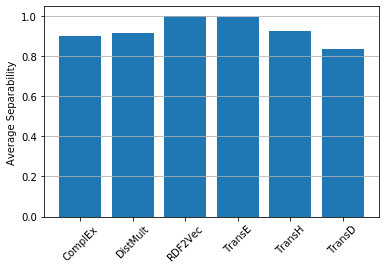

In [20]:
results = []
mods = [m for m in models if "HolE" not in m]
labels = []
for m in MODEL:
    labels.append(m)
    df = load_df(m, sym=False)
    res = df.f1.mean()
    results.append(res)
    print(f"{m:15} {res:.4f}")

plt.grid(axis="y")
plt.bar(labels, results)
# You can specify a rotation for the tick labels in degrees or with keywords.
plt.xticks(labels, labels, rotation=45)
# Pad margins so that markers don't get clipped by the axes
#plt.margins(0.2)
# Tweak spacing to prevent clipping of tick-labels
plt.subplots_adjust(bottom=0.15)
#plt.legend()

plt.ylabel("Average Separability")
#plt.title(f"Separability for different distances and class sizes for {model_name}")
#plt.savefig(f"results/separability/img/average_separability_all.png", format="png")
#plt.savefig(f"results/separability/img/average_separability_all.eps", format="eps")
plt.show()

In [21]:
df.head()

,a,b,ca,cb,taxo,geom,mixed,prec,rec,f1,acc,model,hsize,gsize,cos,euc,neuc,taxcos,taxeuc,taxneuc
0,dbo:Cleric,dbo:NaturalEvent,17063,249,3.333333,0.512041,1.922687,0.948276,0.964912,0.956522,0.962121,TransD_50d_50e,490.837223,2061.234339,0.889385,5.589391,1.333706,0.767939,0.665468,0.808088
1,dbo:Cleric,dbo:Royalty,17063,11505,0.666667,0.141766,0.404216,0.507246,0.479452,0.492958,0.520000,TransD_50d_50e,13743.336250,14011.060452,0.853943,6.541413,1.306861,0.469678,0.437150,0.517220
2,dbo:Cleric,dbo:Bridge,17063,4289,4.116667,0.583570,2.350118,0.929577,0.942857,0.936170,0.940000,TransD_50d_50e,6854.927595,8554.718406,0.913823,6.471621,1.351905,0.862111,0.797674,0.897056
3,dbo:Cleric,dbo:MountainRange,17063,2011,3.666667,0.506547,2.086607,0.929412,0.963415,0.946108,0.940000,TransD_50d_50e,3597.954598,5857.789088,0.839959,5.552135,1.296117,0.780042,0.698590,0.830448
4,dbo:Cleric,dbo:Curler,17063,771,1.116667,0.213757,0.665212,0.610169,0.461538,0.525547,0.566667,TransD_50d_50e,1475.336212,3627.061207,0.899542,7.582119,1.341300,0.538533,0.543030,0.576529


In [35]:
def load_df(m, sym=True):
    m = MODEL.get(m, m)
    df = pd.read_csv(f"results/separability/sep_sized_{m}.csv", index_col=0)
    if sym:
        return symmetrize(df)
    return df

In [36]:
from scipy import stats

df = load_df("TransE", False)
df["hsize"] = df[["ca", "cb"]].apply(stats.hmean, axis=1)

In [37]:
(df.ca+df.cb).min()

28

In [38]:
df.hsize.min(), df.hsize.max()

(12.857142857142858, 1428824.609114834)

In [26]:
steps = np.logspace(np.log(df.hsize.min()-1), np.log(df.hsize.max()+1), 10)

In [27]:
df = load_df("ComplEx", False)
df["hsize"] = df[["ca", "cb"]].apply(stats.hmean, axis=1)
df["gsize"] = df[["ca", "cb"]].apply(stats.gmean, axis=1)

print(df.hsize.max(), df.gsize.max())

2094456.950428857 2255812.6057598437


In [28]:
df = load_df("TransE", False)
df["hsize"] = df[["ca", "cb"]].apply(stats.hmean, axis=1)
df["gsize"] = df[["ca", "cb"]].apply(stats.gmean, axis=1)

print(df.hsize.max(), df.gsize.max())

1428824.609114834 1431800.2061443499


In [40]:

datatable = {}
col = "hsize"
for m in MODEL:
    df = load_df(m, False)
    df["hsize"] = df[["ca", "cb"]].apply(stats.hmean, axis=1)
    df["gsize"] = df[["ca", "cb"]].apply(stats.gmean, axis=1)
    steps = np.logspace(np.log10(df[col].min()-1), np.log10(df[col].max()+1), 10)
    x, y = aggregate(df[col], df.f1, steps)
    datatable[m] = (x, y)  

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


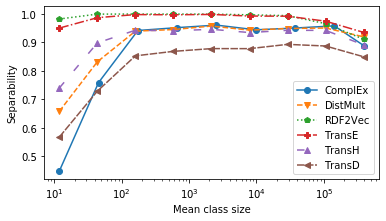

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


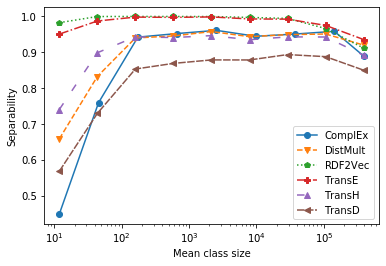

In [56]:
linestyles = ["solid", "dashed", "dotted", "dashdot",  (0, (5, 10)), (0, (5, 1))]
markers = ["o", "v", "p", "P", "^", "<"]
style = [dict(linestyle=ls, marker=mk) for ls, mk in zip(linestyles, markers)]
plt.figure(figsize=(6, 3))
plt.tight_layout()
plt.subplots_adjust(bottom=0.15, top=0.95)
m1 = datatable["TransE"][0][-1]
m2 = datatable2["TransE"][0][-1]
for s, (m, (x, y)) in zip(style, datatable.items()):
    if m == "ComplEx":
        x[-1] = m2
    plt.plot(x, y, label=m, **s)
plt.xscale("log")
plt.xlabel("Mean class size")
plt.ylabel("Separability")
plt.legend()
plt.savefig(os.path.join(RESDIR, "separability_vs_hsize_small.eps"), format="eps")
plt.savefig(os.path.join(RESDIR, "separability_vs_hsize_small.png"), format="png")
plt.savefig(os.path.join(RESDIR, "separability_vs_hsize_small.svg"), format="svg")
plt.show()

for s, (m, (x, y)) in zip(style, datatable2.items()):
    if m == "ComplEx":
        x[-1] = m2
    plt.plot(x, y, label=m, **s)
plt.xscale("log")
plt.xlabel("Mean class size")
plt.ylabel("Separability")
plt.legend()
plt.savefig(os.path.join(RESDIR, "separability_vs_gsize.eps"), format="eps")
plt.savefig(os.path.join(RESDIR, "separability_vs_gsize.png"), format="png")
plt.savefig(os.path.join(RESDIR, "separability_vs_gsize.svg"), format="svg")
plt.show()

In [153]:
from libs.table import display_table

steps = [1e0, 1e2, 1e3, 1e5, 1e6]
dsteps = [0, 1, 2, 3, 5]
#print(f"{'model':20}\t1-99\t100-1K\t1K-100K\t100K+)
table = [
    ["Model", 
     *"1-99 100-1K 1K-100K 100K+".split(),
     *"<1 1-2 2-3 3+".split(),
     "Avg"
    ]
]
ftable = [[]]
for m in MODEL:
#steps = np.logspace(0, 6, 7)
    df = load_df(m, False)
    df["hsize"] = df[["ca", "cb"]].apply(stats.hmean, axis=1)
    df["gsize"] = df[["ca", "cb"]].apply(stats.gmean, axis=1)
    x, y = aggregate(df.hsize, df.f1, steps)
    x, y2 = aggregate(df.taxo, df.f1, dsteps)
    a = df.f1.mean()
    ftable.append([m, *it.chain(y, y2), a])
    table.append([m, *(f"{x:.5f}".replace(".", ",") for x in it.chain(y, y2, [a]))])
    #res = "\t".join(f"{x:.3f}" for x in y)
    #print(f"{m:20}\t{res}")
      
display_table(table)

Model,1-99,100-1K,1K-100K,100K+,<1,1-2,2-3,3+,Avg
ComplEx,"0,60580","0,92862","0,95550","0,94756","0,68043","0,79485","0,90210","0,93958","0,89710"
DistMult,"0,74723","0,93330","0,95093","0,94504","0,64599","0,79076","0,92943","0,96573","0,91603"
RDF2Vec,"0,99252","0,99949","0,99819","0,95500","0,97228","0,99786","0,99858","0,99893","0,99668"
TransE,"0,97466","0,99559","0,99587","0,96686","0,92916","0,98523","0,99813","0,99917","0,99201"
TransH,"0,83252","0,93793","0,94232","0,93175","0,70166","0,83511","0,94656","0,96166","0,92516"
TransD,"0,65059","0,84699","0,87752","0,88060","0,63508","0,75314","0,85466","0,86749","0,83483"


In [151]:
ftable[3][-1] < ftable[4][-1]

True

In [142]:
from libs.table import display_table

display_table(table)

Model,1-99,100-1K,1K-100K,100K+
ComplEx,0.606,0.929,0.955,0.948
DistMult,0.747,0.933,0.951,0.945
RDF2Vec,0.993,0.999,0.998,0.955
TransE,0.975,0.996,0.996,0.967
TransH,0.833,0.938,0.942,0.932
TransD,0.651,0.847,0.878,0.881


In [122]:
datatable["ComplEx"][0][-2:], datatable["TransE"][0][-3:], datatable["RDF2Vec"][0][-3:]

([142906.2725441247, 547093.3912013513],
 [28927.62870261536, 106137.36419018118, 389424.9401860114],
 [28927.62870261536, 106137.36419018118, 389424.9401860114])

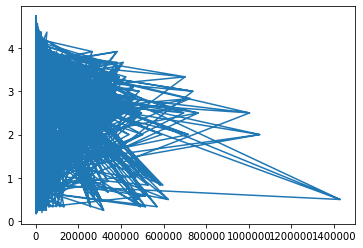

In [111]:
df = load_df("TransE", False)
df["hsize"] = df[["ca", "cb"]].apply(stats.hmean, axis=1)

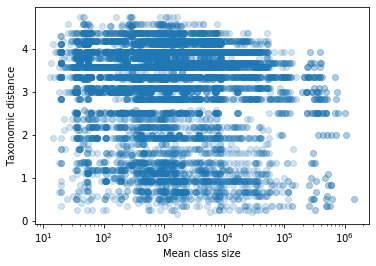

In [113]:
plt.scatter(df.hsize, df.taxo, alpha=0.2)
plt.xscale("log")
plt.xlabel("Mean class size")
plt.ylabel("Taxonomic distance")
plt.show()

In [156]:
classes = set(df.a.unique()) | set(df.b.unique())

print(*list(classes)[:15])

dbo:ClericalAdministrativeRegion dbo:Beverage dbo:TennisTournament dbo:RadioStation dbo:Cleric dbo:Activity dbo:Place dbo:MotorsportSeason dbo:SpeedwayRider dbo:Bridge dbo:Castle dbo:OfficeHolder dbo:City dbo:CricketTeam dbo:GridironFootballPlayer


In [160]:
EFILE = "data/word_embeddings/crawl-300d-2M.vec"

with open(EFILE, "r") as f:
    n_words, dim = map(int, next(f).split())
    E = np.zeros((n_words, dim))
    words = {}
    for i, line in enumerate(f):
        word, *vec = line.split()
        words[word] = i
        E[i] = np.array(vec, dtype=float)

In [163]:
import re 
  
def camel_case_split(s):  
    return [s.lower() for s in re.findall(r'[A-Z](?:[a-z]+|[A-Z]*(?=[A-Z]|$))', s)]

def extract_keywords(cls):
    return camel_case_split(cls.replace("dbo:", "").replace("owl:", ""))

extract_keywords("dbo:ClericalAdministrativeRegion")

['clerical', 'administrative', 'region']

In [164]:
vocab = set(it.chain(*[extract_keywords(cls) for cls in classes]))
assert not vocab - word.keys()

289

In [168]:
class_vector = {}

for c in classes:
    kw = extract_keywords(c)
    class_vector[c] = sum(E[words[k]] for k in kw) / len(kw)

In [177]:
class_vector["owl:Thing"] = E[words["thing"]]

In [183]:
from scipy.spatial.distance import euclidean, cosine

def word_distance(l):
    a, b = l
    return euclidean(class_vector[a], class_vector[b])

def word_cdistance(l):
    a, b = l
    return cosine(class_vector[a], class_vector[b])

def word_norm_distance(l):
    a, b = l
    va, vb = class_vector[a], class_vector[b]
    return euclidean(va/np.linalg.norm(va), vb/np.linalg.norm(vb))

word_norm_distance(["dbo:OfficeHolder", "dbo:Politician"])

1.1676344850294431

In [184]:
df["cos"] = df[["a", "b"]].apply(word_cdistance, axis=1)
df["euc"] = df[["a", "b"]].apply(word_distance, axis=1)
df["neuc"] = df[["a", "b"]].apply(word_norm_distance, axis=1)
df.head()

,a,b,ca,cb,taxo,geom,mixed,prec,rec,f1,acc,model,hsize,gsize,cos,euc,taxcos,taxeuc,neuc
0,dbo:Cleric,dbo:NaturalEvent,17063,249,3.333333,0.512041,1.922687,0.948276,0.964912,0.956522,0.962121,TransD_50d_50e,490.837223,2061.234339,0.889385,5.589391,0.767939,0.665468,1.333706
1,dbo:Cleric,dbo:Royalty,17063,11505,0.666667,0.141766,0.404216,0.507246,0.479452,0.492958,0.520000,TransD_50d_50e,13743.336250,14011.060452,0.853943,6.541413,0.469678,0.437150,1.306861
2,dbo:Cleric,dbo:Bridge,17063,4289,4.116667,0.583570,2.350118,0.929577,0.942857,0.936170,0.940000,TransD_50d_50e,6854.927595,8554.718406,0.913823,6.471621,0.862111,0.797674,1.351905
3,dbo:Cleric,dbo:MountainRange,17063,2011,3.666667,0.506547,2.086607,0.929412,0.963415,0.946108,0.940000,TransD_50d_50e,3597.954598,5857.789088,0.839959,5.552135,0.780042,0.698590,1.296117
4,dbo:Cleric,dbo:Curler,17063,771,1.116667,0.213757,0.665212,0.610169,0.461538,0.525547,0.566667,TransD_50d_50e,1475.336212,3627.061207,0.899542,7.582119,0.538533,0.543030,1.341300


In [179]:
df["taxcos"] = 0.5 * (df.taxo/df.taxo.max() + df.cos/df.cos.max())
df["taxeuc"] = 0.5 * (df.taxo/df.taxo.max() + df.euc/df.euc.max())
df.head()

,a,b,ca,cb,taxo,geom,mixed,prec,rec,f1,acc,model,hsize,gsize,cos,euc,taxcos,taxeuc
0,dbo:Cleric,dbo:NaturalEvent,17063,249,3.333333,0.512041,1.922687,0.948276,0.964912,0.956522,0.962121,TransD_50d_50e,490.837223,2061.234339,0.889385,5.589391,0.767939,0.665468
1,dbo:Cleric,dbo:Royalty,17063,11505,0.666667,0.141766,0.404216,0.507246,0.479452,0.492958,0.520000,TransD_50d_50e,13743.336250,14011.060452,0.853943,6.541413,0.469678,0.437150
2,dbo:Cleric,dbo:Bridge,17063,4289,4.116667,0.583570,2.350118,0.929577,0.942857,0.936170,0.940000,TransD_50d_50e,6854.927595,8554.718406,0.913823,6.471621,0.862111,0.797674
3,dbo:Cleric,dbo:MountainRange,17063,2011,3.666667,0.506547,2.086607,0.929412,0.963415,0.946108,0.940000,TransD_50d_50e,3597.954598,5857.789088,0.839959,5.552135,0.780042,0.698590
4,dbo:Cleric,dbo:Curler,17063,771,1.116667,0.213757,0.665212,0.610169,0.461538,0.525547,0.566667,TransD_50d_50e,1475.336212,3627.061207,0.899542,7.582119,0.538533,0.543030


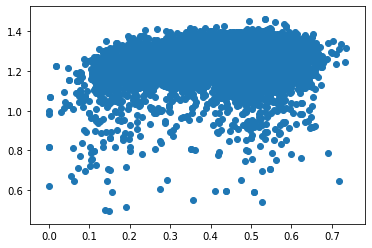

In [186]:
plt.scatter(df.geom, df.neuc)
plt.show()

In [187]:
for m in MODEL:
    df = load_df(m, sym=False)
    df["hsize"] = df[["ca", "cb"]].apply(stats.hmean, axis=1)
    df["gsize"] = df[["ca", "cb"]].apply(stats.gmean, axis=1)
    df["cos"] = df[["a", "b"]].apply(word_cdistance, axis=1)
    df["euc"] = df[["a", "b"]].apply(word_distance, axis=1)
    df["neuc"] = df[["a", "b"]].apply(word_norm_distance, axis=1)
    df["taxcos"] = 0.5 * (df.taxo/df.taxo.max() + df.cos/df.cos.max())
    df["taxeuc"] = 0.5 * (df.taxo/df.taxo.max() + df.euc/df.euc.max())
    df["taxneuc"] = 0.5 * (df.taxo/df.taxo.max() + df.neuc/df.neuc.max())
    df.to_csv(f"results/separability/data/sep_{m}.csv")
    print(f"{m} done")

ComplEx done
DistMult done
RDF2Vec done
TransE done
TransH done
TransD done
